# Week 3 - Machine learning - regressions

Regression belongs like classification to the field of **supervised learning**. 


<div class="alert alert-block alert-warning">
<i class="fa fa-info-circle"></i>&nbsp; 
<strong>Regression predicts numerical values</strong> 
in contrast to classification which predicts categories.
</div>

<div class="alert alert-block alert-warning">
<i class="fa fa-info-circle"></i>&nbsp; 
    Other differences are:

* Accuracy is measured differently


* Other algorithms
</div>

## Set up and load data

In [1]:
# Common imports
import os
import numpy as np
import pandas as pd

# To plot pretty figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib notebook
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings = lambda *a, **kw: None

# to make this notebook's output identical at every run
np.random.seed(42)

In [2]:
# Scikit-Learn ≥0.20 is required
import sklearn

We use as an example the **Boston housing data** (from `sklearn`), which contains 13 attributes of housing markets around Boston. The data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts

The objective is to **predict the value of prices** of the house using the given features

In [2]:
from sklearn.datasets import load_boston
data = load_boston() # object is a dictionary
data.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

Data Set Characteristics:

In [4]:
print(data['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [5]:
X_full, y_full = data.data, data.target
n_samples = X_full.shape[0]
n_features = X_full.shape[1]

In [6]:
X_df=pd.DataFrame(X_full, columns=data['feature_names'])
X_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


No null values in the dataset:

In [7]:
X_df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

## Exploratory Data Analysis

### Quantity to predict= price (`target`) 

Before the regression, let us inspect the features and their distributions. 

In [8]:
y_full.shape

(506,)

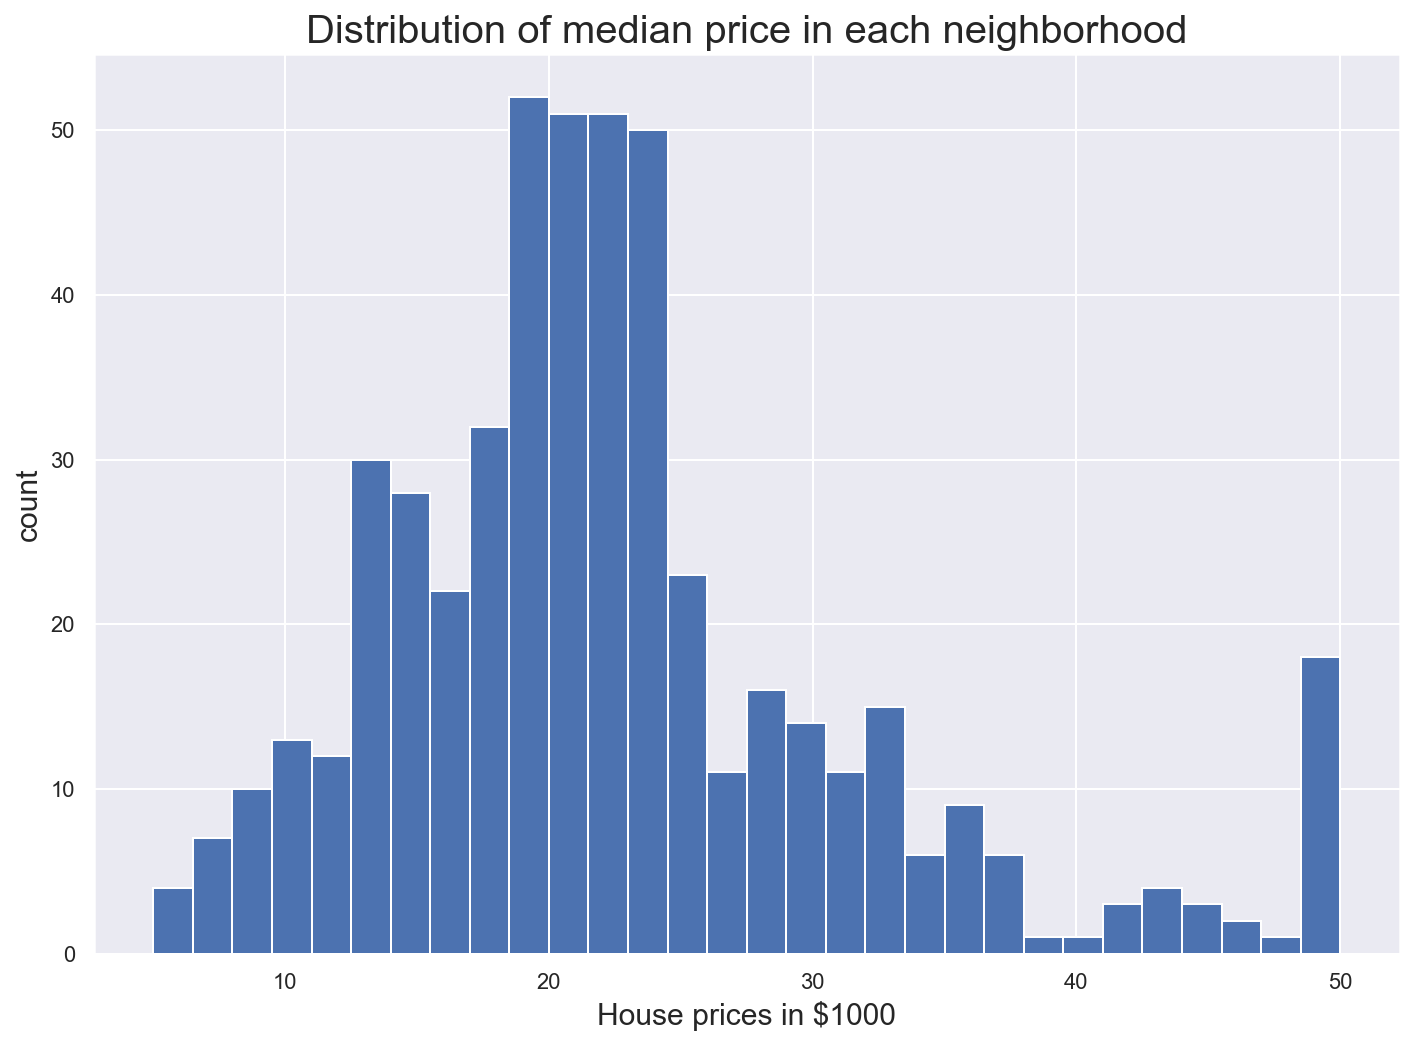

In [9]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.hist(y_full, bins=30)
plt.xlabel("House prices in $1000", size=15)
plt.ylabel('count', size=15)
plt.title('Distribution of median price in each neighborhood', size=20)
plt.show()

### Features used for prediction

In [10]:
X_full.shape

(506, 13)

#### Distributions
**Histogram plots** to look at the distribution

In [ ]:
X_df.hist(bins=50, figsize=(20,15))
plt.show()

#### Correlations

**Boston Correlation Heatmap Example with Seaborn**

The seaborn package offers a heatmap that will allow a two-dimensional graphical representation of the Boston data. The heatmap will represent the individual values that are contained in a matrix are represented as colors.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(8.5,5)})
correlation_matrix = X_df.corr().round(2)
sns.heatmap(correlation_matrix) #annot=True
plt.show()

An important point in selecting features for a linear regression model is to check for multicolinearity. The features RAD, TAX have a correlation of 0.91. These feature pairs are strongly correlated to each other. This can affect the model. Same goes for the features DIS and AGE which have a correlation of -0.75.

Correlation plots:

In [ ]:
from pandas.plotting import scatter_matrix
scatter_matrix(X_df[['DIS', 'AGE','RAD', 'TAX']], figsize=(12, 8))

#### Scatter plot relative to the target (price)

In [ ]:
for feature_name in X_df.columns:
    plt.figure(figsize=(4, 3))
    plt.scatter(X_df[feature_name], y_full, alpha=0.1)
    plt.ylabel('Price', size=15)
    plt.xlabel(feature_name, size=15)
    plt.tight_layout()

What can we say ? 
- The prices increase as the value of RM increases linearly. There are few outliers and the data seems to be capped at 50.

- The prices tend to decrease with an increase in LSTAT. Though it doesn’t look to be following exactly a linear line.

## Prepare the data for ML algorithms

### Drop some labeled observations:

Drop the observations with price >=50 (because of the right censure)

In [ ]:
mask=y_full<50

y_full=y_full[mask==True]
X_full=X_full[mask==True]
X_df=X_df[mask==True]

### Split train test sets 
#### using `train_test_split`
Pure ramdomness of the sampling method

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full,test_size=0.2, random_state=1)

In [ ]:
print("train data", X_train.shape, y_train.shape)
print("test data", X_test.shape,  y_test.shape)

#### Stratifier Sampling using `StratifiedShuffleSplit`
If a variable is known to be key for the prediction (e.g. income), it can be a good idea to ensure that the distribution of this variable in the test set is similar to its distribution in the overall data. 

First, if the stratifying variable is continuous, we create a corresponding categorical variable:

In [ ]:
X_df['quantile'] = pd.qcut(X_df['LSTAT'],
                              q=[0, .2, .4, .6, .8, 1],
                              labels=[1, 2, 3, 4, 5])

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(X_df, X_df["quantile"]):
    df_X_strat_train = X_df.loc[train_index]
    df_X_strat_test = X_df.loc[test_index]
    X_strat_train = X_full[train_index]
    X_strat_test = X_full[test_index]
    y_strat_train = y_full[train_index]
    y_strat_test = y_full[test_index]

In [ ]:
df_X_strat_train['quantile'].value_counts()/df_X_strat_train.shape[0]

In [ ]:
X_df['quantile'].value_counts()/X_df.shape[0]

Remove the stratifying variable from the features:

In [ ]:
for set_ in (df_X_strat_train, df_X_strat_test):
    set_.drop('quantile', axis=1, inplace=True)

In the case of time series data, you can also rely on the time structure of the data to split the train and sample set. 

#### Data cleaning
The missing features should be:
1. dropped
2. imputed to some value (zero, the mean, the median...)

In [ ]:
from sklearn.impute import SimpleImputer # takes care of missing values
imputer = SimpleImputer(strategy="median")
imputer.fit(X_strat_test) # train the imputer on the train data
X_strat_tr_train=imputer.transform(X_strat_train)

In [ ]:
from sklearn.preprocessing import OrdinalEncoder # for categorical values

#### Feature Scaling
Most common scaling methods: 
- **standardization**= normalization by substracting the mean and dividing by the standard deviation (values are not bounded)
- **Min-max scaling**= normalization by substracting the minimum and dividing by the maximum (values between `0` and `1`)

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

## Select and Train a Model
**Regression algorithm** (we consider firs the `LinearRegression`, more algorithms will be discussed later):
### First algorithm: Simple Linear Regression

In [ ]:
# our first machine learning model
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

<div class="alert alert-block alert-warning">
    <i class="fa fa-warning"></i>&nbsp;<strong><code>scikit-learn</code> API</strong>

In <code>scikit-learn</code> all regression algorithms have:
<ul>
    <li>a <strong><code>fit()</code></strong> method to learn from data, and</li>
    <li>and a subsequent <strong><code>predict()</code></strong> method for predicting numbers from input features.</li>
</ul>
</div>

In [ ]:
lin_reg.fit(X_train, y_train)
print("R-squared for training dataset:{}".
      format(np.round(lin_reg.score(X_train, y_train), 2)))

In [ ]:
lin_reg.fit(X_train_scaled, y_train)
print("R-squared for training dataset & scaled features:{}".
      format(np.round(lin_reg.score(X_train_scaled, y_train), 2)))

In [ ]:
lin_reg.fit(X_strat_train, y_strat_train)
print("R-squared for training dataset & stratified sampling :{}".
      format(np.round(lin_reg.score(X_strat_train, y_strat_train), 2)))

Coefficients of the linear regression:

In [ ]:
features = list(X_df.columns)

print('The coefficients of the features from the linear model:')
print(dict(zip(features, [round(x, 2) for x in lin_reg.coef_])))

### Metrics / error measures   

`scikit-learn` offers the following metrics for measuring regression quality:

#### Mean absolute error

This is the metric we used before. Taking absolute values before adding up the deviatons assures that deviations with different signs can not cancel out.

<div class="alert alert-block alert-warning">
    <i class="fa fa-info-circle"></i>&nbsp; <strong>mean absolute error</strong> is defined as 


$$
\frac{1}{n} \left(\, |y_1 - \hat{y}_1| \, + \, |y_2 - \hat{y}_2| \, + \, \ldots \,+ \,|y_n - \hat{y}_n| \,\right)
$$


</div>


The name of the corresponding score in `scikit-learn` is `neg_mean_absolute_error`.


#### Mean squared error

Here we replace the absolute difference by its squared difference. Squaring also insures positive differeces.


<div class="alert alert-block alert-warning">
    <i class="fa fa-info-circle"></i>&nbsp; <strong>mean squared error</strong> is defined as 



$$
\frac{1}{n} \left(\, (y_1 - \hat{y}_1)^2 \, + \, (y_2 - \hat{y}_2)^2 \, \, \ldots \,+ \,(y_n - \hat{y}_n)^2 \,\right)
$$


</div>



This measure is more sensitive to outliers: A few larger differences contribute more significantly to a larger mean squared error. The name of the corresponding score in `scikit-learn` is `neg_mean_squared_error`.


#### Median absolute error

Here we replace mean calculation by median. 

<div class="alert alert-block alert-warning">
    <i class="fa fa-info-circle"></i>&nbsp; <strong>median absolute error</strong> is defined as 



$$
\text{median}\left(\,|y_1 - \hat{y}_1|, \,|y_2 - \hat{y}_2|, \,\ldots, \,|y_n - \hat{y}_n| \, \right)
$$


</div>


This measure is less sensitive to outliers than the metrics we discussed before: A few larger differences will not contribute significantly to a larger error value. The name of the corresponding score in `scikit-learn` is `neg_median_absolute_error`.

#### Mean squared log error

The formula for this metric can be found [here](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-log-error). 

This metric is recommended when your target values are distributed over a huge range of values, like popoluation numbers. 
The previous error metrics would put a larger weight on large target values. One could consider relative deviations to compensate such effects but relative deviations come with other problems like division by zero.


The name is `neg_mean_squared_log_error`

In [ ]:
from sklearn.metrics import mean_squared_error

# in-sample performance
y_train_pred = lin_reg.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
print("RMS: %s" % train_rmse) # = np.sqrt(np.mean((predicted - expected) ** 2)) 

**Exercice**: compute 
1. the out-of-sample mean squarred error
2. mean  absolute error (using `mean_absolute_error`)

In [ ]:
# out-of-sample performance
y_test_pred = lin_reg.predict(X_test)        
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
print("RMS: %s" % test_rmse) 

In [ ]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(y_test, y_test_pred)
lin_rmae = np.sqrt(lin_mae)
print("RMAE: %s" % lin_rmae) 

#### Explained variance and $r^2$-score

Two other scores to mention are *explained variance* and $r^2$-score. For both larger values indicate better regression results.

The formula for [r2 can be found here](https://scikit-learn.org/stable/modules/model_evaluation.html#r2-score), the score takes values in the range $0 .. 1$. The name within `scikit-learn` is `r2`.

The formula for [explained variance](https://scikit-learn.org/stable/modules/model_evaluation.html#explained-variance-score), the score takes values up to $1$. The name within `scikit-learn` is `explained_variance`.


In [ ]:
from sklearn.metrics import r2_score
r2=round(r2_score(y_test, y_test_pred), 2)
print("R2: %s" % r2) 

In [ ]:
# Regplot
g=sns.regplot(x= y_test_pred, y=y_test, x_bins=100)
g=g.set_title("Test sample")
plt.xlabel("Predicted prices: $\hat{Y}_i$")
plt.ylabel("Prices: $Y_i$")
plt.annotate('R2={}'.format(r2),
            xy=(1, 0),  xycoords='axes fraction',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.annotate('Notes: 100 binned',
            xy=(0, 0),  xycoords='figure fraction',
            horizontalalignment='left',
            verticalalignment='bottom')
plt.plot([0, 50], [0, 50], '--k')
plt.axis('tight')
plt.tight_layout()
plt.show(g)

In [ ]:
## plt.figure(figsize=(4, 3))
plt.scatter(x=y_test_pred,y=y_test)
plt.plot([0, 50], [0, 50], '--k')
plt.axis('tight')
plt.xlabel('Predicted price ($1000s)')
plt.ylabel('True price ($1000s)')
plt.tight_layout()

In [ ]:
#Let us plot how good given and predicted values match on the training data set (sic !).
def plot_fit_quality(values_test, predicted):
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)

    x = np.arange(len(predicted))
    plt.scatter(x, predicted - values_test, color='steelblue', marker='o') 

    plt.plot([0, len(predicted)], [0, 0], "k:")
    
    max_diff = np.max(np.abs(predicted - values_test))
    plt.ylim([-max_diff, max_diff])
    
    plt.ylabel("error")
    plt.xlabel("sample id")

    plt.subplot(1, 2, 2)

    plt.scatter(x, (predicted - values_test) / values_test, color='steelblue', marker='o') 
    plt.plot([0, len(predicted)], [0, 0], "k:")
    plt.ylim([-.5, .5])
      
    plt.ylabel("relative error")
    plt.xlabel("sample id")

plot_fit_quality(y_test, y_test_pred)

### Some algorithms from sklearn

- `sklearn.linear_model.LinearRegression` is a linear regression method, which only works well for target values which can be described as a linear combination of feature values.


- `sklearn.kernel_ridge.KernelRidge` is [documented here](https://scikit-learn.org/stable/modules/kernel_ridge.html#kernel-ridge). It combines the kernel trick from SVMs with classical least squares regression.


- `sklearn.svm.SVR` is an extension of support vector classification concept to regression, [you find examples here](https://scikit-learn.org/stable/modules/svm.html#svm-regression)


- `sklearn.neighbors.KNeighborsRegressor` extends the idea of nearest neighbour classification to regression: Search for similar data points in the learning data set and compute the predicted value from the values from the neighbourhood, e.g. by averaging or by linear interpolation. [Documentation is available here](https://scikit-learn.org/stable/modules/neighbors.html#regression)


- `sklearn.tree.DecisionTreeRegressor` expands the concept of decision trees to regression [is documented here](https://scikit-learn.org/stable/modules/tree.html#regression).




**Exercise**: train other regression algorithms and look at the goodeness of fit

In [ ]:
from sklearn.linear_model import Ridge
ridge_reg=Ridge(alpha=2, solver='cholesky')       
ridge_reg.fit(X_train, y_train)

y_train_pred=ridge_reg.predict(X_train)
y_test_pred = ridge_reg.predict(X_test)        
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
print("train RMS: %s" % train_rmse) 
print("test RMS: %s" % test_rmse) 
print("train R2: %s" % round(r2_score(y_train, y_train_pred), 2)) 
print("test R2: %s" % round(r2_score(y_test, y_test_pred), 2)) 

#### Ridge regression

In [ ]:
from sklearn.linear_model import Ridge
ridge_reg=Ridge(alpha=1)       
ridge_reg.fit(X_train, y_train)

y_train_pred=ridge_reg.predict(X_train)
y_test_pred = ridge_reg.predict(X_test)        
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
print("train RMS: %s" % train_rmse) 
print("test RMS: %s" % test_rmse) 
print("train R2: %s" % round(r2_score(y_train, y_train_pred), 2)) 
print("test R2: %s" % round(r2_score(y_test, y_test_pred), 2)) 

In [ ]:
print('The coefficients of the features from the Ridge model:')
print(dict(zip(features, [round(x, 2) for x in ridge_reg.coef_])))

#### Lasso regression

In [ ]:
from sklearn.linear_model import Lasso
lasso_reg=Lasso(alpha=1)       
lasso_reg.fit(X_train, y_train)

y_test_pred = lasso_reg.predict(X_test)        
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
print("test RMS: %s" % test_rmse) 
print("train R2: %s" % round(r2_score(y_train, y_train_pred), 2)) 
print("test R2: %s" % round(r2_score(y_test, y_test_pred), 2)) 

In [ ]:
print('The coefficients of the features from the Lasso model:')
print(dict(zip(features, [round(x, 2) for x in lasso_reg.coef_])))

#### Elastic Net

In [ ]:
from sklearn.linear_model import ElasticNet
elanet_reg=ElasticNet(random_state=0)
elanet_reg.fit(X_train, y_train)

y_test_pred = elanet_reg.predict(X_test)        
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
print("test RMS: %s" % test_rmse) 
print("train R2: %s" % round(r2_score(y_train, y_train_pred), 2)) 
print("test R2: %s" % round(r2_score(y_test, y_test_pred), 2)) 

In [ ]:
print('The coefficients of the features from the Lasso model:')
print(dict(zip(features, [round(x, 2) for x in elanet_reg.coef_])))

#### Setting the **regularization parameter**: generalized Cross-Validation.

In [ ]:
from sklearn import linear_model
lassocv_reg = linear_model.LassoCV(alphas=np.logspace(-6, 6, 13))
lassocv_reg.fit(X_train, y_train)
alpha=lassocv_reg.alpha_ 
print("Best alpha", alpha)

Then re-run the model using the best alpha:

In [ ]:
lasso_reg=Lasso(alpha=alpha)       

lasso_reg.fit(X_train, y_train)

y_train_pred=lasso_reg.predict(X_train)
y_test_pred = lasso_reg.predict(X_test)        
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
print("test RMS: %s" % test_rmse) 
print("train R2: %s" % round(r2_score(y_train, y_train_pred), 2)) 
print("test R2: %s" % round(r2_score(y_test, y_test_pred), 2)) 

## Fine-tuning of the Model

### Model Evaluation using Cross-Validation

In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict
# Perform 6-fold cross validation
scores = cross_val_score(elanet_reg, X_train, y_train, cv=5)
scores

In [ ]:
# Make cross validated predictions
y_train_pred_cv = cross_val_predict(elanet_reg, X_train, y_train, cv=5)

In [ ]:
## plt.figure(figsize=(4, 3))
plt.scatter(y_train, y_train_pred_cv)
plt.plot([0, 50], [0, 50], '--k')
plt.axis('tight')
plt.xlabel('True price ($1000s)')
plt.ylabel('Predicted price ($1000s)')
plt.tight_layout()

In [ ]:
accuracy =r2_score(y_train, y_train_pred_cv)
print('Cross-Predicted Accuracy:', accuracy)

#### Hyperparameters tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = [
  {'alpha': [0.0001, 0.001, 0.01, 0.1 ,1, 10]},
 ]
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(elanet_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_train, y_train)

The best hyperparameter combination found:

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_estimator_

Score of each hyperparameter combination tested during the grid search:

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [ ]:
df_cvres=pd.DataFrame(cvres)
df_cvres['mean_test_score_pos_sqrt']=df_cvres['mean_test_score'].apply(lambda x: np.sqrt(-x))
df_cvres['log_param_alpha']=df_cvres['param_alpha'].apply(lambda x: np.log(x))
df_cvres.head()

You can vizualize the grid search results:

In [ ]:
_, ax = plt.subplots(1,1)
plt.plot(df_cvres["log_param_alpha"], df_cvres["mean_test_score_pos_sqrt"])
ax.set_title("Grid Search", fontsize=20, fontweight='bold')
ax.set_xlabel("$\log (alpha)$", fontsize=16)
ax.set_ylabel('Avg. mean test score', fontsize=16)

Other possibility: for randomized search of hyperparameters

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

What is not covered today:
- more advanced regression algorithms (gradient boosting, random forest)
- classification algorithm
- pipelines